# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=False)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols)#, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"])#, drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [2]:
## Imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import confusion_matrix, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns

#Set seed
seed = 23

#set colormap
sns.set_palette(palette="magma")

## Task 1 (Classifiers and fairness considerations)  
1. Starting from the template, train two different classifiers on the training data: a white-box 
model using logistic regression, and a black-box model using a random forest. Consider 
feature engineering and scaling steps necessary for some of these classifiers and summarize 
the necessary changes in your report. For both models, report on the accuracy of the 
classifier on the test set.

### Preprocessing

In [3]:
#One one column left that is not boolean, AGEP.
#We scale this to between 0-1 because the penalty term is sensitive to scale. I think.
    
column_trans = ColumnTransformer(
    [('scaler', MinMaxScaler(),['AGEP'])], 
    remainder='passthrough')

column_trans.fit(X_train) #Use the training data only to fit the scaler.

X_train.AGEP = column_trans.transform(X_train)[:,0]

X_test.AGEP = column_trans.transform(X_test)[:,0] #Fit both train and test using the fitted scaler.

### Logistic Regression Model: white box

In [4]:
LRclf = LogisticRegression(max_iter=5000, 
                            penalty='l2', 
                            C=0.98497534359086438, 
                            tol=1e-4,
                            solver='saga', 
                            random_state=seed)
LRclf.fit(X_train, y_train)
LR_score = LRclf.score(X_test, y_test)

### Random Forest Model: black box

In [5]:
RFclf = RandomForestClassifier(max_depth=2, 
                                random_state=seed, 
                                n_jobs=-1, 
                                n_estimators=200)
RFclf.fit(X_train, y_train)
RF_score = RFclf.score(X_test, y_test)

In [6]:
print(f'Logistic Reg  score: {LR_score:.2}\nRandom Forest score: {RF_score:.2}')

Logistic Reg  score: 0.77
Random Forest score: 0.75


2. For each classifier, measure statistical parity, equalized odds (both in terms of  T = 0  and  T 
= 1 ), and equality of outcome (both in terms of  S = 0  and  S = 1 ) (Lecture 2). Plot the 
results and discuss the differences that you observe.

### Statistical Parity

$P(S=1|G=2) = P(S=1|G=1)$

### Equalised Odds

$P(S=1|G=2, T=1) = P(S=1|G=1, T=1)$

$P(S=1|G=2, T=0) = P(S=1|G=1, T=0)$

### Equalised Outcomes

$P(T=1|G=2, S=1) = P(T=1|G=1, S=1)$

$P(T=1|G=2, S=0) = P(T=1|G=1, S=0)$

$S$ = Predicted value

$T$ = True value (going to use $A$ instead because ```.T``` is a thing in pandas already)

$G$ = Group status

In [7]:
def make_df(model, X_test):
    df = pd.DataFrame(model.predict(X_test), columns=['S'])
    df['G'] = group_test
    df['A'] = y_test
    return df

def stat_parity(df):
    g1 = sum(df[df.G==1].S)/df[df.G==1].shape[0]
    g2 = sum(df[df.G==2].S)/df[df.G==2].shape[0]
    return g1, g2

def equal_odds(df, target=1):
    g1 = sum(df[(df.G==1)&(df.A==target)].S)/df[(df.G==1)&(df.A==target)].shape[0]
    g2 = sum(df[(df.G==2)&(df.A==target)].S)/df[(df.G==2)&(df.A==target)].shape[0]

    return g1, g2

def equal_outcomes(df, s=1):
    g1 = sum(df[(df.G==1)&(df.S==s)].A)/df[(df.G==1)&(df.S==s)].shape[0]
    g2 = sum(df[(df.G==2)&(df.S==s)].A)/df[(df.G==2)&(df.S==s)].shape[0]

    return g1, g2

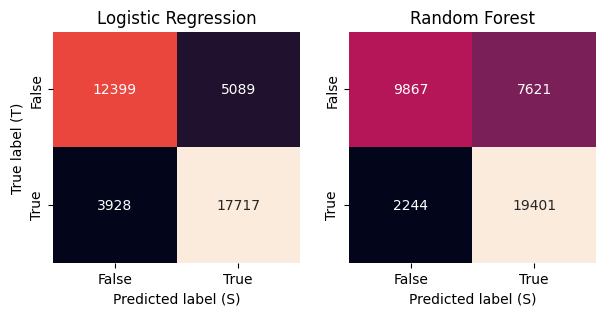

In [8]:
_, ax = plt.subplots(1,2, figsize=(7,3))
cm = confusion_matrix(y_test, LRclf.predict(X_test))
sns.heatmap(cm, annot=True, fmt=".0f", 
            xticklabels=['False', 'True'], 
            yticklabels=['False', 'True'],
            ax=ax[0], 
            cbar=False)

ax[0].set_ylabel('True label (T)')
ax[0].set_xlabel('Predicted label (S)')
ax[0].set_title('Logistic Regression')


cm = confusion_matrix(y_test, RFclf.predict(X_test))
sns.heatmap(cm, annot=True, fmt=".0f", 
            xticklabels=['False', 'True'], 
            yticklabels=['False', 'True'],
            ax=ax[1], 
            cbar=False)

ax[1].set_xlabel('Predicted label (S)')
ax[1].set_title('Random Forest');

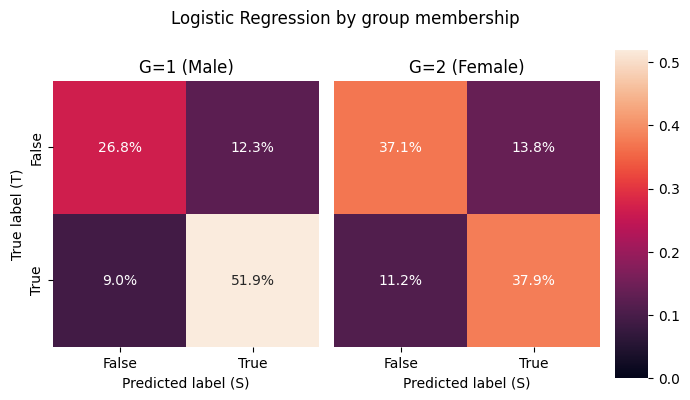

In [9]:
res = make_df(LRclf, X_test)

G_1 = res[res.G==1]
fig, ax = plt.subplots(1,3, figsize=(7,4), gridspec_kw={'width_ratios': [4, 4, 0.5]})
cm = confusion_matrix(G_1.A, G_1.S)
cm = cm/G_1.shape[0]
sns.heatmap(cm, annot=True, fmt=".1%", 
            xticklabels=['False', 'True'], 
            yticklabels=['False', 'True'],
            ax=ax[0],
            vmin=0, vmax=.52,
            cbar=True,
            cbar_ax=ax[2],
            square=True)

ax[0].set_ylabel('True label (T)')
ax[0].set_xlabel('Predicted label (S)')
ax[0].set_title('G=1 (Male)')

G_2 = res[res.G==2]
cm = confusion_matrix(G_2.A, G_2.S)
cm = cm/G_2.shape[0]
sns.heatmap(cm, annot=True, fmt=".1%",
            xticklabels=['False', 'True'],
            yticklabels=False,
            ax=ax[1],
            vmin=0, vmax=.52,
            cbar=False,
            square=True)

ax[1].set_xlabel('Predicted label (S)')
ax[1].set_title('G=2 (Female)')
fig.suptitle('Logistic Regression by group membership')
fig.tight_layout();

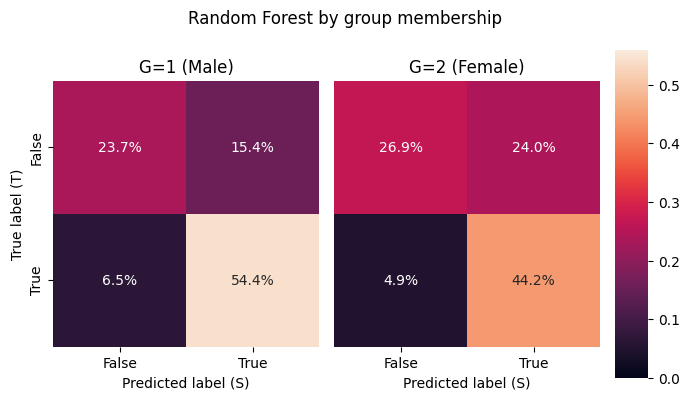

In [10]:
res = make_df(RFclf, X_test)

G_1 = res[res.G==1]
fig, ax = plt.subplots(1,3, figsize=(7,4), gridspec_kw={'width_ratios': [4, 4, 0.5]})
cm = confusion_matrix(G_1.A, G_1.S)
cm = cm/G_1.shape[0]
sns.heatmap(cm, annot=True, fmt=".1%", 
            xticklabels=['False', 'True'], 
            yticklabels=['False', 'True'],
            ax=ax[0],
            vmin=0, vmax=.56,
            cbar=True,
            cbar_ax=ax[2],
            square=True)

ax[0].set_ylabel('True label (T)')
ax[0].set_xlabel('Predicted label (S)')
ax[0].set_title('G=1 (Male)')

G_2 = res[res.G==2]
cm = confusion_matrix(G_2.A, G_2.S)
cm = cm/G_2.shape[0]
sns.heatmap(cm, annot=True, fmt=".1%",
            xticklabels=['False', 'True'],
            yticklabels=False,
            ax=ax[1],
            vmin=0, vmax=.56,
            cbar=False,
            square=True)

ax[1].set_xlabel('Predicted label (S)')
ax[1].set_title('G=2 (Female)')
fig.suptitle('Random Forest by group membership')
fig.tight_layout();

In [11]:
g1, g2 = stat_parity(make_df(LRclf, X_test))

print(f'Logistic Regression statisical parity check: \ngroup1 {g1:.3}\ngroup2 {g2:.3}')

print()
g1, g2 = stat_parity(make_df(RFclf, X_test))

print(f'Random Forest statisical parity check: \ngroup1 {g1:.3}\ngroup2 {g2:.3}')

Logistic Regression statisical parity check: 
group1 0.642
group2 0.517

Random Forest statisical parity check: 
group1 0.698
group2 0.682


In [12]:
## Target == True

g1, g2 = equal_odds(make_df(LRclf, X_test))

print(f'Logistic Regression equalised odds check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

print()
g1, g2 = equal_odds(make_df(RFclf, X_test))

print(f'Random Forest equalised odds check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

Logistic Regression equalised odds check: 
group1 0.85
group2 0.77

Random Forest equalised odds check: 
group1 0.89
group2 0.9


In [13]:
## Target == False

g1, g2 = equal_odds(make_df(LRclf, X_test), target=0)

print(f'Logistic Regression equalised odds check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

print()
g1, g2 = equal_odds(make_df(RFclf, X_test), target=0)

print(f'Random Forest equalised odds check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

Logistic Regression equalised odds check: 
group1 0.32
group2 0.27

Random Forest equalised odds check: 
group1 0.39
group2 0.47


In [14]:
## Selected == True

g1, g2 = equal_outcomes(make_df(LRclf, X_test))

print(f'Logistic Regression equalised outcomes check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

print()
g1, g2 = equal_outcomes(make_df(RFclf, X_test))

print(f'Random Forest equalised outcomes check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

Logistic Regression equalised outcomes check: 
group1 0.81
group2 0.73



Random Forest equalised outcomes check: 
group1 0.78
group2 0.65


In [15]:
## Selected == False

g1, g2 = equal_outcomes(make_df(LRclf, X_test), s=0)

print(f'Logistic Regression equalised outcomes check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

print()
g1, g2 = equal_outcomes(make_df(RFclf, X_test), s=0)

print(f'Random Forest equalised outcomes check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

Logistic Regression equalised outcomes check: 
group1 0.25
group2 0.23

Random Forest equalised outcomes check: 
group1 0.22
group2 0.15


3. Change the classification pipeline to (approximately) fulfill one of the fairness criteria by post-
processing the results. How did the intervention influence the different fairness criteria, how 
did it change the accuracy of the classification?

In [16]:
#TPR using method shown in class, used as a sanity check in a moment
yhat = LRclf.predict(X_test)
group0_tpr = np.mean(yhat[(y_test==1)&(group_test==1)])
group1_tpr = np.mean(yhat[(y_test==1)&(group_test==2)])

group0_tpr, group1_tpr

(0.851784007645747, 0.7725822422708769)

(array([0.85189172]), array([], dtype=float64))

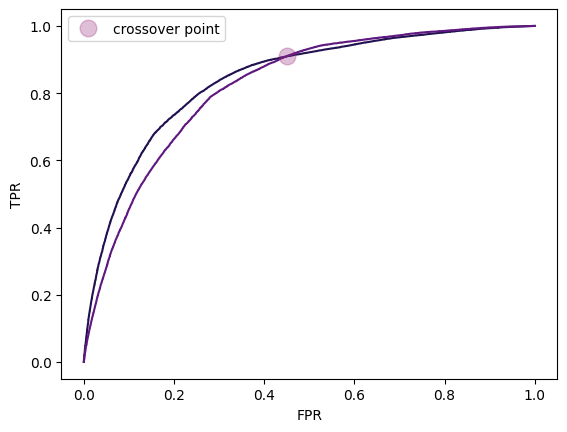

In [17]:
y_true_1 = y_train[group_train==1]
scores_1 = LRclf.predict_proba(X_train[group_train==1])[:,1]

fpr_1, tpr_1, thresholds_1 = roc_curve(y_true_1, scores_1, pos_label=True)

y_true_2 = y_train[group_train==2]
scores_2 = LRclf.predict_proba(X_train[group_train==2])[:,1]

fpr_2, tpr_2, thresholds_2 = roc_curve(y_true_2, scores_2, pos_label=True)

plt.plot(fpr_1, tpr_1)
plt.plot(fpr_2, tpr_2)

plt.plot(0.45, 0.91, ms=12, 
        marker='o', alpha=0.3, 
        label='crossover point', ls='')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend();

##Sanity check to make sure this is close enough to the tpr calc'd using method from class
tpr_1[(0.49999<thresholds_1)&(thresholds_1<0.50001)], tpr_2[(0.49999<thresholds_2)&(thresholds_2<0.50001)]

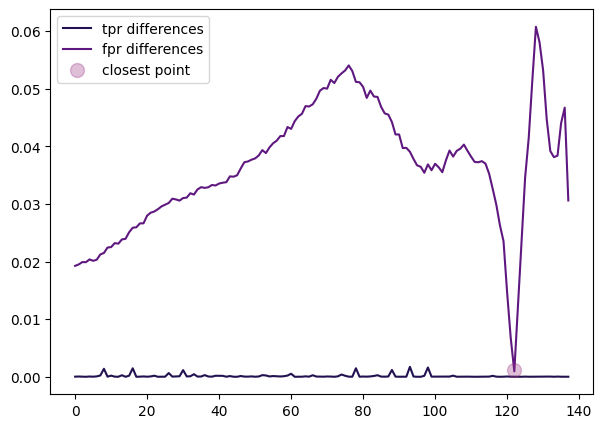

In [18]:
#plot the difference between the TPR and the FPR 
#for the two groups at different thresholds
#We want to choose a threshold for each group that
#makes the FPRs and TPRs as close as possible for each group
#as this will equalise the odds across the groups

tpr_diff = []
fpr_diff = []
thresholds = []
for p in np.arange(0.3, 0.99, 0.005):
    #print(f'\n{p}')
    tpr_diff.append(abs(tpr_1[tpr_1>p][0] - tpr_2[tpr_2>p][0]))
    fpr_diff.append(abs(fpr_1[tpr_1>p][0] - fpr_2[tpr_2>p][0]))
    thresholds.append((thresholds_1[tpr_1>p][0], thresholds_2[tpr_2>p][0]))

_, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(tpr_diff, label='tpr differences')
ax.plot(fpr_diff, label='fpr differences')
ax.plot(122,0.00111, ms=10, 
        marker='o', alpha=0.3, 
        label='closest point', ls='')

plt.legend();

In [19]:
#choose the point with smallest differences between the groups tpr, and fpr rates.

n = np.argmin(fpr_diff) #we are using the fpr to choose the point as the tpr is relatively constant

a, b = thresholds[n]
a, b, n

(0.39349512434204076, 0.3090268657577433, 122)

In [20]:
scores_1 = LRclf.predict_proba(X_test[group_test==1])[:,1]
scores_2 = LRclf.predict_proba(X_test[group_test==2])[:,1]
y_true_1 = y_test[group_test==1]
y_true_2 = y_test[group_test==2]

y_pred_1 = [1 if i >= 0.5 else 0 for i in scores_1] #standard LR
y_pred_2 = [1 if i >= 0.5 else 0 for i in scores_2] #standard LR

tot_true = np.hstack([y_true_1, y_true_2])
tot_pred = np.hstack([y_pred_1, y_pred_2])

print('Standard Logistic Regression Model')
print(f'Group1 accuracy: {1-(sum(abs(y_true_1 - y_pred_1))/len(y_pred_1)):.2f}\nGroup2 accuracy: {1-(sum(abs(y_true_2 - y_pred_2))/len(y_pred_2)):.2f}\nTotal  accuracy: {1-(sum(abs(tot_true - tot_pred))/len(tot_pred)):.2f}')

Standard Logistic Regression Model
Group1 accuracy: 0.79
Group2 accuracy: 0.75
Total  accuracy: 0.77


In [21]:
y_pred_1 = [1 if i >= a else 0 for i in scores_1] #using threshold for equalised odds
y_pred_2 = [1 if i >= b else 0 for i in scores_2] #using threshold for equalised odds

tot_true = np.hstack([y_true_1, y_true_2])
tot_pred = np.hstack([y_pred_1, y_pred_2])

print('Using threshold for each group')
print(f'Group1 accuracy: {1-(sum(abs(y_true_1 - y_pred_1))/len(y_pred_1)):.2f}\nGroup2 accuracy: {1-(sum(abs(y_true_2 - y_pred_2))/len(y_pred_2)):.2f}\nTotal  accuracy: {1-(sum(abs(tot_true - tot_pred))/len(tot_pred)):.2f}')


Using threshold for each group
Group1 accuracy: 0.77
Group2 accuracy: 0.73
Total  accuracy: 0.75


Accuracy falls slightly across both groups as well as for the whole.

So now we will look at the confusion matrix and the fairness measures to see what the effect has been

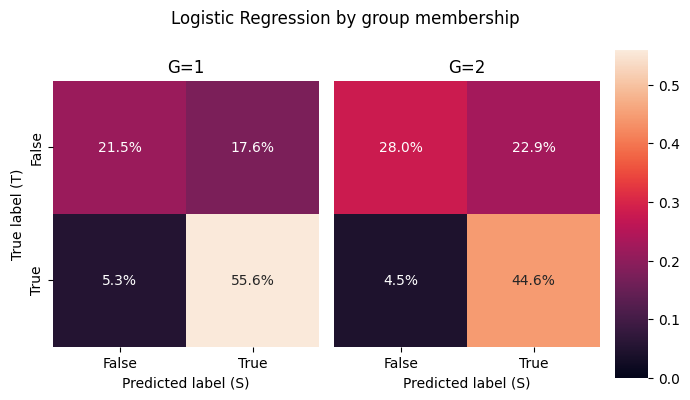

In [22]:
res = pd.DataFrame(tot_pred, columns=['S'])
res['G'] = [1]*len(y_true_1) + [2]*len(y_true_2)
res['A'] = tot_true

G_1 = res[res.G==1]
fig, ax = plt.subplots(1,3, figsize=(7,4), gridspec_kw={'width_ratios': [4, 4, 0.5]})
cm = confusion_matrix(G_1.A, G_1.S)
cm = cm/G_1.shape[0]
sns.heatmap(cm, annot=True, fmt=".1%", 
            xticklabels=['False', 'True'], 
            yticklabels=['False', 'True'],
            ax=ax[0],
            vmin=0, vmax=.56,
            cbar=True,
            cbar_ax=ax[2],
            square=True)

ax[0].set_ylabel('True label (T)')
ax[0].set_xlabel('Predicted label (S)')
ax[0].set_title('G=1')

G_2 = res[res.G==2]
cm = confusion_matrix(G_2.A, G_2.S)
cm = cm/G_2.shape[0]
sns.heatmap(cm, annot=True, fmt=".1%",
            xticklabels=['False', 'True'],
            yticklabels=False,
            ax=ax[1],
            vmin=0, vmax=.56,
            cbar=False,
            square=True)

ax[1].set_xlabel('Predicted label (S)')
ax[1].set_title('G=2')
fig.suptitle('Logistic Regression by group membership')
fig.tight_layout();

In [23]:
#We changed the thresholds to make fair according to the equalised odds criteria
#previous T=1 0.91/0.92, T=0, 0.43/0.49

t1_odds = equal_odds(res)
t0_odds = equal_odds(res, target=0)

print(f'Target = 1')
print(f'Equalised odds: \nGroup 1 {t1_odds[0]:.2f}\nGroup 2 {t1_odds[1]:.2f}')
print()
print(f'Target = 0')
print(f'Equalised odds: \nGroup 1 {t0_odds[0]:.2f}\nGroup 2 {t0_odds[1]:.2f}')

Target = 1
Equalised odds: 
Group 1 0.91
Group 2 0.91

Target = 0
Equalised odds: 
Group 1 0.45
Group 2 0.45


In [24]:
#Previous 0.64/0.51
sp = stat_parity(res)
print(f'Statistical parity:')
print(f'Group 1 {sp[0]:.2f}\nGroup 2 {sp[1]:.2f}')
print('\nStatisical parity is also improved, although not achieved')

Statistical parity:
Group 1 0.73
Group 2 0.67

Statisical parity is also improved, although not achieved


In [25]:
#Previous s=1: 0.77/0.64, s=0: 0.19/0.13

t1_out = equal_outcomes(res)
t0_out = equal_outcomes(res, s=0)

print(f'S = 1')
print(f'Equalised outcomes: \nGroup 1 {t1_out[0]:.2f}\nGroup 2 {t1_out[1]:.2f}')
print()
print(f'S = 0')
print(f'Equalised outcomes: \nGroup 1 {t0_out[0]:.2f}\nGroup 2 {t0_out[1]:.2f}')

print('\nNot much change to equalised outcomes')

S = 1
Equalised outcomes: 
Group 1 0.76
Group 2 0.66

S = 0
Equalised outcomes: 
Group 1 0.20
Group 2 0.14

Not much change to equalised outcomes


## Task 2 (Explaining white-box models)  
1. Explain the trained logistic regression model. In particular, discuss which features in the 
model are deemed most relevant. Reflect on the interpretation. Does it fit your intuition 
about the prediction task?
2. Pick one data point in the test dataset. Find a counterfactual data point that contrasts the 
outcome of the inference on this data point (e.g., "had X had feature P >=, then it had been 
classified as ..."). Describe how you used the model explanation to find such a counterfactual.


Interpreting odds ratios:

“For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times as large as the odds that the observation is not in (y class) when all other variables are held constant.”

https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1

In [26]:
odds = pd.DataFrame(LRclf.coef_[0], 
             X_train.columns,
             columns=['coef'])

odds['odds'] = np.exp(odds.coef)
odds['abs_odds'] = abs(odds.coef)
odds = odds.sort_values(by='abs_odds', ascending=False).drop('abs_odds', axis=1)

odds.head(10)

,coef,odds
AGEP,2.876831,17.757909
SCHL_24.0,1.893129,6.640111
SCHL_23.0,1.863795,6.448162
SCHL_22.0,1.674363,5.335396
SCHL_21.0,1.173845,3.234405
COW_8.0,-1.113020,0.328565
SCHL_4.0,-0.993403,0.370315
COW_5.0,0.716335,2.046918
SCHL_8.0,-0.705455,0.493884
SCHL_5.0,-0.697996,0.497581


In [27]:
probs = LRclf.predict_proba(X_test)[:,1]
probs = pd.DataFrame(probs, columns=['probs'])

poss = probs[(0.4999<probs.probs)&(probs.probs<0.5001)]

In [28]:
df = pd.DataFrame(X_test)
df['y'] = y_test
df['prob'] = LRclf.predict_proba(X_test)[:,1]

poss = df[(0.4999<df.prob)&(df.prob<0.5001)]
test = pd.DataFrame(poss.iloc[0]).T #select a datapoint close to being classified as the other

print(LRclf.predict(test[test.columns[:-2]])) #currently predicted False
test

[False]


,AGEP,HINS1_1,HINS1_2,HINS2_1,HINS2_2,HINS4_1,HINS4_2,CIT_1,CIT_2,CIT_3,...,RAC1P_7,RAC1P_8,RAC1P_9,ENG_1.0,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan,y,prob
294318,0.116883,True,False,False,True,False,True,True,False,False,...,False,False,False,False,False,False,False,True,True,0.499937


In [29]:
test.AGEP

column_trans.named_transformers_['scaler'].inverse_transform(test)[0][0] #originally aged 26

26.0

In [30]:
test.AGEP += 0.0001 #we increase AGEP by a very small amount as this is likely to make a large effect according to the odds ratio

print(LRclf.predict(test[test.columns[:-2]])) #now it is flipped

column_trans.named_transformers_['scaler'].inverse_transform(test)[0][0] #by making them 26.008... Hmmmm.

[ True]


26.007699999999996

## Task 3 (Model-agnostic explanations)  
1. Both for the white-box and the black-box classifier, use the  shap  module to explain 
predictions. Contrast the two models to each other: What are similarities, how do they differ?
2. For logistic regression, compare the model-agnostic explanation to your analysis in Task 2. 
How do the explanations differ?

In [204]:
import shap

explainer = shap.Explainer(LRclf, X_train, feature_names=np.array(data.columns))
shap_values = explainer(X_test)

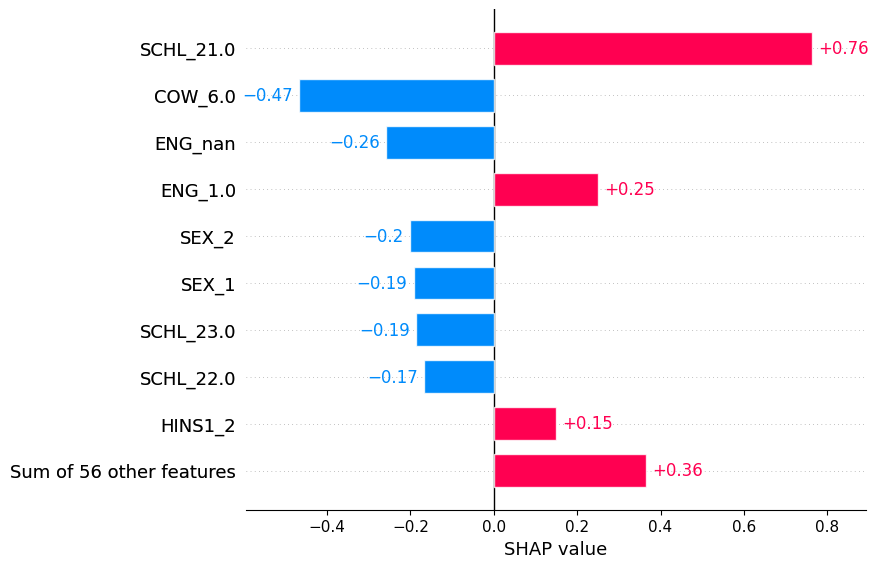

In [205]:
dp = 23 #change datapoint here

shap.plots.bar(shap_values[dp])

In [206]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[dp].values, features=X_test.columns, link='logit')

In [207]:
shap_values_a = explainer(pd.DataFrame(X_test.iloc[dp]).T) #Let's just look at this one data point else I can't get it to work.

group_idx = list()
shap_agg_full = np.zeros((shap_values_a.shape[0], len(feature_names)))

for i in feature_names:
    group_idx.append([n for n, l in enumerate(data.columns) if l.startswith(i)])
    
for ii, g in enumerate(group_idx):
    shap_agg_full[:, ii] = shap_values_a[:,g].values.sum()
    
shap.force_plot(explainer.expected_value, shap_agg_full[0], features=feature_names, link='logit')

In [208]:
LRclf.predict_proba(pd.DataFrame(X_test.iloc[dp]).T)[0,1]

0.6857347128610111

## Task 4 (Reflection)  
Given the outcome of your study, which classifier is most suited for the prediction task under 
accuracy, explainability, and fairness considerations?